# Obdelava podatkov o Evroviziji

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path

pd.options.display.max_rows = 10
%matplotlib inline

bdp = pd.read_csv(os.path.join('podatki', 'bdp.csv'))
meje = pd.read_csv(os.path.join('podatki', 'meje.csv'))
glasovi = pd.read_csv(os.path.join('podatki', 'esc.csv'), sep=';')
uvrstitve = pd.read_csv(os.path.join('podatki', 'uvrstitve.csv'))

Najprej uredimo tabelo glasovi, da pomečemo proč nepomembne stolpce in preimenujemo indekse

In [2]:
glasovi = glasovi.drop(columns=['Edition', '(semi-) final', 'Jury or Televoting', 'Duplicate'])
glasovi = glasovi.rename(columns={'Year': 'leto', 'From country': 'od države', 'To country': 'državi', 'Points      ' : 'točke'})

#### Zdaj imamo vse tabele pripravljene. Začnimo z raziskovanjem povezave uspeha in bdp.

             država      bdp  točke
0    United Kingdom   960428     63
1           Germany  1859310    128
2            France  1175737     74
3             Spain   425089     17
4          Portugal    82359     73
..              ...      ...    ...
872          Serbia    18106     44
873          Russia   265834    185
874          Sweden   192863    167
875        Slovenia    12130     52
876      San Marino      745     38

[877 rows x 3 columns]


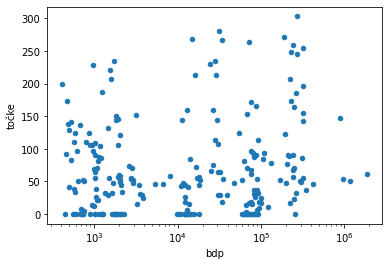

In [3]:
bdp_in_uvrstitve = pd.merge(bdp, uvrstitve).drop(columns='leto')
povprečja_točk_po_bdp = bdp_in_uvrstitve.groupby('bdp', as_index=False).mean()
print(bdp_in_uvrstitve)

povprečja_točk_po_bdp.plot.scatter(x = 'bdp', y = 'točke').set_xscale('log')

Iz točk si težko predstavljamo korelacijo, zato poskušajmo podatke aproksimirati s polinomi.

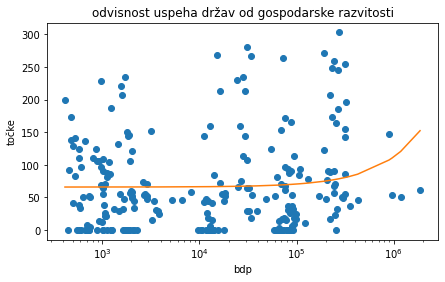

In [4]:
import scipy.optimize as opt

def linearni_polinom(x, a, b):
    return a * x + b

def prilegajoč_se_polinom(polinom):
    koeficienti, _ = opt.curve_fit(polinom, povprečja_točk_po_bdp['bdp'], povprečja_točk_po_bdp['točke'])
    polinom = polinom(povprečja_točk_po_bdp['bdp'], *koeficienti)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(povprečja_točk_po_bdp['bdp'], povprečja_točk_po_bdp['točke'], 'o')
    ax.plot(povprečja_točk_po_bdp['bdp'], polinom)

    ax.set_xscale('log')
    ax.set_xlabel('bdp')
    ax.set_ylabel('točke')
    ax.set_title('odvisnost uspeha držav od gospodarske razvitosti')
    
prilegajoč_se_polinom(linearni_polinom)

Zdi se, da velja, da so razvitejše države uspešnejše. Aproksimirajmo namesto z linearnim polinomom še s polinomom višje stopnje.

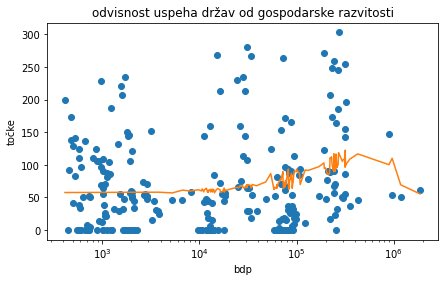

In [5]:
def polinom_pete_stopnje(x, a, b, c, d, e, f):
    return a * x ** 5 + b * x ** 4 + c * x ** 3 + d * x ** 2 + e * x + f

prilegajoč_se_polinom(polinom_pete_stopnje)

Krivulja je načeloma naraščujoča. Izpostavil bi desni del, kjer pade. Poglejmo, zaradi katerih držav se to zgodi (to so tiste z največjim bdp).

In [6]:
države = bdp_in_uvrstitve.groupby('država').mean()
države_ki_kvarijo_krivuljo = države[države.bdp > 9 ** 6]
države_ki_kvarijo_krivuljo

,bdp,točke
država,,
France,1175737.0,51.346154
Germany,1859310.0,62.000000
Italy,891770.0,147.400000
United Kingdom,960428.0,53.730769


Vidimo, da so te države Francija, Nemčija in Velika Britanija. Zanimivo, da se te države izkažejo nesorazmerno svoji gospodarski moči (če bi bila korelacija linearna), čeprav imajo od leta 2000 naprej avtomatsko vstopnico v finale.

Poglejmo si še, katere druge države najbolj odstopajo od linearne aproksimacije.

In [12]:
države['razmerje'] = države.točke / države.bdp
povprečno_razmerje = države.razmerje.mean()

države['odstopanje'] = države.razmerje - povprečno_razmerje
države.sort_values('odstopanje')

,bdp,točke,razmerje,odstopanje
država,,,,
Andorra,1.013000e+03,0.000000,0.000000,-0.012562
Monaco,2.263000e+03,0.000000,0.000000,-0.012562
Germany,1.859310e+06,62.000000,0.000033,-0.012529
France,1.175737e+06,51.346154,0.000044,-0.012518
United Kingdom,9.604280e+05,53.730769,0.000056,-0.012506
...,...,...,...,...
Moldova,1.107067e+03,61.000000,0.055101,0.042538
Bosnia & Herzegovina,1.048944e+03,67.500000,0.064350,0.051788
Azerbaijan,1.809167e+03,120.000000,0.066329,0.053767


K tem podatkom bi dodal le še opombo, da sta Andora in Monako le nekajkrat sodelovala in nikoli prišla v finale. Po drugi strani je zanimivo, da so najuspešnejše države po tem kriteriju ravno Kavkaške države.